# Load libraries

In [1]:
%matplotlib inline

import os
import math

import configparser

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import sys
sys.path.append('../..')

from scripps.utils import read_datasets, norm1d, bayesian_linear_regression

import seaborn as sns

In [364]:
#np.random.seed(23) #Not working

# Load all mark2cure citizen scientist annotations

In [2]:
CF = read_datasets.get_configuration()

def read_disease_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_citizen_disease', 'files1')
    anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c_citizen_disease', 'files{}'.format(i))
        anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

def read_phenotype_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_citizen_phenotype', 'files1')
    anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c_citizen_phenotype', 'files{}'.format(i))
        anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

In [3]:
disease_annotations = read_disease_annotations()
phenotype_annotations = read_phenotype_annotations()

# Load original annotations

In [4]:
def read_both_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c', 'files1')
    anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c', 'files{}'.format(i))
        anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

def sanity_check(annotations, columns, values):
    for col in columns:
        assert set(annotations[col].unique()) == set(values)


In [5]:
mixed_annotations = read_both_annotations()
sanity_check(mixed_annotations, ['Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5'], ['I-Disease', 'I-Phenotype', 'I-Disease_Pheno', 'O'])

# Filter relevant rows

In [6]:
def get_relevant_rows(annotations):
    relevant = annotations[['Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5']] != 'O'
    relevant = annotations[relevant.all(axis=1)]
    return relevant

In [7]:
relevant_annotations = get_relevant_rows(mixed_annotations)

In [8]:
disease_annotations = disease_annotations.iloc[relevant_annotations.index]
phenotype_annotations = phenotype_annotations.iloc[relevant_annotations.index]

# Initialize latent variables

In [372]:
K = disease_annotations.shape[0]
J = disease_annotations.shape[1] - 1

latent = {}

latent['theta'] = np.zeros(K)
latent['d_alpha'] = np.zeros(J)
latent['d_beta'] = np.zeros(J)
latent['d_z'] = np.zeros((K, J))

latent['p_alpha'] = np.zeros(J)
latent['p_beta'] = np.zeros(J)
latent['p_z'] = np.zeros((K, J))

#Should these be separate for disease and phenotype?
latent['b0'] = np.zeros(2)
latent['B0_scale'] = 1
latent['m0'] = np.zeros(K) #TODO: ask HS regarding changing certain values here.
latent['C0_scale'] = 1

latent['K'] = K
latent['J'] = J

# Define functions for resampling using Gibbs sampling

In [373]:
def __get_alpha_beta_z(mode):
    if mode == 'disease':
        alpha = latent['d_alpha']
        beta = latent['d_beta']
        z = latent['d_z']
    else:
        alpha = latent['p_alpha']
        beta = latent['p_beta']
        z = latent['p_z']
    return alpha, beta, z
    

In [374]:
def __resample_z(alpha, beta, z, annotations):
    interval = [-100, 100] #Should this be changed?
    for k in range(K):
    #for k in annotations.index:
        for j in range(J):
            mean = alpha[j] + beta[j]*latent['theta'][k]
            std_dev = 1
            '''
            if(annotations['Annotator{}'.format(j+1)][k] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][k] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
            '''
            if(annotations['Annotator{}'.format(j+1)][annotations.index[k]] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][annotations.index[k]] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
    
def resample_z(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    if mode == 'disease':
        annotations = disease_annotations
    else:
        annotations = phenotype_annotations
    __resample_z(alpha, beta, z, annotations)

In [375]:
def __resample_alpha_beta(alpha, beta, z):
    for j in range(J):
        Y = z[:, j]
        X = np.vstack((np.ones(K), latent['theta'])).T
        
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['b0'], latent['B0_scale'], 1)
        sample = np.random.multivariate_normal(WN, VN)
        alpha[j] = sample[0]
        beta[j] = sample[1]

def resample_alpha_beta(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    __resample_alpha_beta(alpha, beta, z)

In [376]:
def resample_theta():
    for k in range(K):
        #Y = latent['d_z'][k, :] - latent['d_alpha'] + latent['p_z'][k, :] - latent['p_alpha']
        #X = latent['d_beta'] + latent['p_beta']
        Y = np.concatenate(((latent['d_z'][k, :] - latent['d_alpha']), (latent['p_z'][k, :] - latent['p_alpha'])), axis=0)
        X = np.concatenate((latent['d_beta'], latent['p_beta']), axis=0)
        X = np.reshape(X, (-1, 1))
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['m0'][k], latent['C0_scale'], 1)
        latent['theta'][k] = np.random.normal(WN, math.sqrt(VN))

In [377]:
def save_latent_variables():
    #TODO: save to csv.
    pass


def resample():
    resample_z('disease')
    resample_z('phenotype')
    resample_theta()
    resample_alpha_beta('disease')
    resample_alpha_beta('phenotype')
    
    save_latent_variables()
    
def has_converged():
    #TODO
    pass
    
def run_sampling(num_iter, thresh, print_freq=50):
    thetas = []
    d_alphas = []
    d_betas = []
    p_alphas = []
    p_betas = []
    for it in xrange(1, num_iter+1):
        resample()
        if it%print_freq == 0:
            print 'Iter {}/{} done.'.format(it, num_iter)
        if has_converged():
            break
        if it > thresh:
            thetas.append(np.array(latent['theta']))
            d_alphas.append(np.array(latent['d_alpha']))
            p_alphas.append(np.array(latent['p_alpha']))
            d_betas.append(np.array(latent['d_beta']))
            p_betas.append(np.array(latent['p_beta']))

    all_values = {}
    all_values['thetas'] = thetas
    all_values['d_alphas'] = d_alphas
    all_values['d_betas'] = d_betas
    all_values['p_alphas'] = p_alphas
    all_values['p_betas'] = p_betas
    
    return all_values

def get_averages(all_values, num_iter, thresh):
    avg_values = {}
    avg_values['theta'] = np.sum(all_values['thetas'], axis=0)/(num_iter - thresh)
    avg_values['d_alpha'] = np.sum(all_values['d_alphas'], axis=0)/(num_iter - thresh)
    avg_values['d_beta'] = np.sum(all_values['d_betas'], axis=0)/(num_iter - thresh)
    avg_values['p_alpha'] = np.sum(all_values['p_alphas'], axis=0)/(num_iter - thresh)
    avg_values['p_beta'] = np.sum(all_values['p_betas'], axis=0)/(num_iter - thresh)
    return avg_values

In [378]:
num_iter = 2000
thresh = 300
all_values = run_sampling(num_iter, thresh)
avg_values = get_averages(all_values, num_iter, thresh)

Iter 50/2000 done.
Iter 100/2000 done.
Iter 150/2000 done.
Iter 200/2000 done.
Iter 250/2000 done.
Iter 300/2000 done.
Iter 350/2000 done.
Iter 400/2000 done.
Iter 450/2000 done.
Iter 500/2000 done.
Iter 550/2000 done.
Iter 600/2000 done.
Iter 650/2000 done.
Iter 700/2000 done.
Iter 750/2000 done.
Iter 800/2000 done.
Iter 850/2000 done.
Iter 900/2000 done.
Iter 950/2000 done.
Iter 1000/2000 done.
Iter 1050/2000 done.
Iter 1100/2000 done.
Iter 1150/2000 done.
Iter 1200/2000 done.
Iter 1250/2000 done.
Iter 1300/2000 done.
Iter 1350/2000 done.
Iter 1400/2000 done.
Iter 1450/2000 done.
Iter 1500/2000 done.
Iter 1550/2000 done.
Iter 1600/2000 done.
Iter 1650/2000 done.
Iter 1700/2000 done.
Iter 1750/2000 done.
Iter 1800/2000 done.
Iter 1850/2000 done.
Iter 1900/2000 done.
Iter 1950/2000 done.
Iter 2000/2000 done.


In [440]:
def get_annotator_bias(alpha, beta):
    # compute xr and xa using above latent vars.
    xa = -(4*alpha - beta*beta)/(4*beta)
    xr = -(4*alpha + beta*beta)/(4*beta)
    return xa, xr

def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x=0, y="zeros", hue=annotator, \
                         data=pos_annos, hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'])
    


In [380]:
print 'theta range: ({}, {})'.format(min(avg_values['theta']), max(avg_values['theta']))

theta range: (-1.27252081647, 2.27871717246)


In [381]:
relevant_annotations = relevant_annotations.reset_index()

In [382]:
pos = pd.DataFrame()
pos = pd.concat([pos, relevant_annotations[['Token', 'Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5']]])
pos = pd.concat([pos, pd.Series(avg_values['theta'])], axis=1)
pos

,Token,Annotator1,Annotator2,Annotator3,Annotator4,Annotator5,0
0,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,1.588087
1,abdominal,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,-0.498895
2,aortic,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,-0.436255
3,aneurysm,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,-0.392996
4,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,1.557895
5,pain,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Phenotype,1.660037
6,abdominal,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,-0.432832
7,aortic,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,-0.360766
8,Acanthosis,I-Disease,I-Disease_Pheno,I-Disease_Pheno,I-Disease_Pheno,I-Disease,0.354537
9,nigricans,I-Disease,I-Disease_Pheno,I-Disease_Pheno,I-Disease_Pheno,I-Disease,0.322725


In [383]:
def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x=0, y="zeros", hue=annotator, data=pos_annos, hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'])

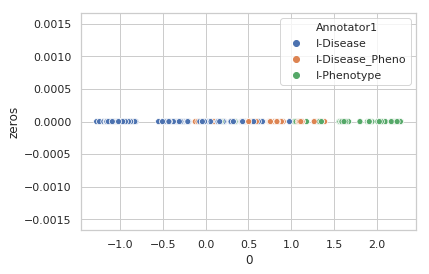

In [384]:
plot_thetas(pos, 'Annotator1')

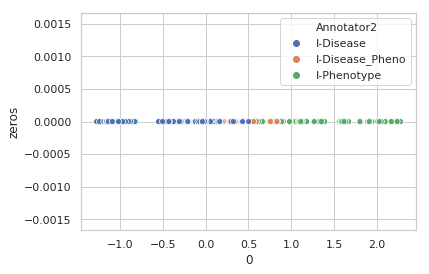

In [385]:
plot_thetas(pos, 'Annotator2')

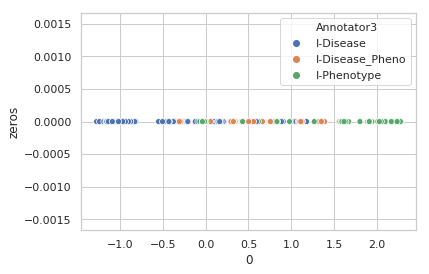

In [386]:
plot_thetas(pos, 'Annotator3')

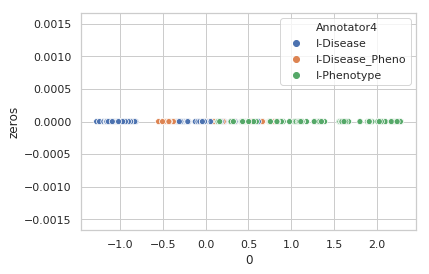

In [387]:
plot_thetas(pos, 'Annotator4')

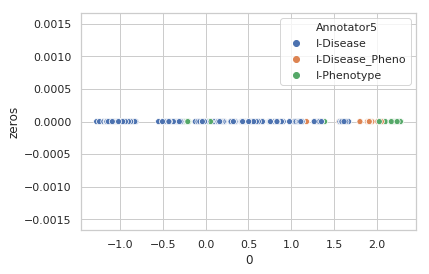

In [388]:
plot_thetas(pos, 'Annotator5')

In [441]:
xda, xdr = get_annotator_bias(avg_values['d_alpha'], avg_values['d_beta'])

In [442]:
xpa, xpr = get_annotator_bias(avg_values['p_alpha'], avg_values['p_beta'])

In [443]:
xda - xdr

array([-0.72339372, -1.55368133, -0.55397658, -1.16727161, -0.29255616])

In [444]:
xpa - xpr

array([0.98247736, 1.28594693, 0.75284286, 0.62350741, 0.42932204])

In [445]:
(xda + xdr)/2

array([1.46084359, 0.75793642, 1.19955202, 0.52902809, 2.66454963])

In [446]:
(xpa + xpr)/2

array([ 0.59159189,  0.52044635,  0.19334959, -0.27568196,  1.77334668])

In [447]:
loc_pd = pd.DataFrame()
#loc_pd['Val'] = ["xda", "xdr", "xpa", "xpr"]
#
#for i in range(5):
#    loc_pd['Annotator{}'.format(i+1)] = [xda[i], xdr[i], xpa[i], xpr[i]]

#loc_pd.index = ["xda", "xdr", "xpa", "xpr"]
loc_pd['xda'] = xda
loc_pd['xdr'] = xdr
loc_pd['xpa'] = xpa
loc_pd['xpr'] = xpr
loc_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
#ax = sns.scatterplot(x=0, y="zeros", data=dis_loc_pd)

In [448]:
loc_pd

,xda,xdr,xpa,xpr,annotator
0,1.099147,1.822540,1.082831,0.100353,Annotator1
1,-0.018904,1.534777,1.163420,-0.122527,Annotator2
2,0.922564,1.476540,0.569771,-0.183072,Annotator3
3,-0.054608,1.112664,0.036072,-0.587436,Annotator4
4,2.518272,2.810828,1.988008,1.558686,Annotator5


    annotator measurement     value
0  Annotator1         xda  1.099147
1  Annotator2         xda -0.018904
2  Annotator3         xda  0.922564
3  Annotator4         xda -0.054608
4  Annotator5         xda  2.518272
5  Annotator1         xdr  1.822540
6  Annotator2         xdr  1.534777
7  Annotator3         xdr  1.476540
8  Annotator4         xdr  1.112664
9  Annotator5         xdr  2.810828

    annotator measurement     value
0  Annotator1         xpa  1.082831
1  Annotator2         xpa  1.163420
2  Annotator3         xpa  0.569771
3  Annotator4         xpa  0.036072
4  Annotator5         xpa  1.988008
5  Annotator1         xpr  0.100353
6  Annotator2         xpr -0.122527
7  Annotator3         xpr -0.183072
8  Annotator4         xpr -0.587436
9  Annotator5         xpr  1.558686


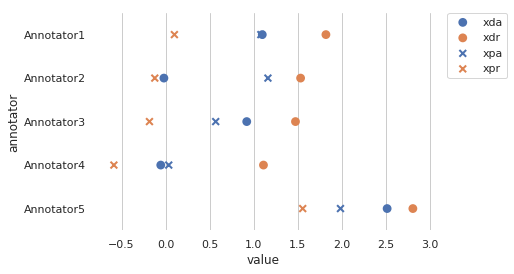

In [449]:
'''
loc_pd = pd.DataFrame()
#loc_pd['disease'] = (xda + xdr)/2
#loc_pd['phenotype'] = (xpa + xpr)/2
loc_pd['disease'] = xda
loc_pd['phenotype'] = xpa
loc_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
'''
dis_pd = pd.DataFrame()
dis_pd['xda'] = xda
dis_pd['xdr'] = xdr
dis_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]

phe_pd = pd.DataFrame()
phe_pd['xpa'] = xpa
phe_pd['xpr'] = xpr
phe_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

print(dis_pd)
print
print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1, ci=None)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1, ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [399]:
dis_loc = (xda + xdr)/2
phe_loc = (xpa + xpr)/2

phe_loc - dis_loc

array([0.8692517 , 0.23749007, 1.00620243, 0.80471005, 0.89120295])

In [18]:
def count_relevant_stats(relevant_annotations, annotator, label):
    return relevant_annotations[relevant_annotations[annotator] == label][annotator].count()

In [27]:
def get_relevant_stats(relevant_annotations, annotator):
    print 'Statistics for {}'.format(annotator)
    print 'Percentage of Disease labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease')/503.0)
    print 'Percentage of Phenotype labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Phenotype')/503.0)
    print 'Percentage of both labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease_Pheno')/503.0)

In [28]:
get_relevant_stats(relevant_annotations, 'Annotator1')

Statistics for Annotator1
Percentage of Disease labels: 0.719681908549
Percentage of Phenotype labels: 0.111332007952
Percentage of both labels: 0.168986083499


In [29]:
get_relevant_stats(relevant_annotations, 'Annotator2')

Statistics for Annotator2
Percentage of Disease labels: 0.709741550696
Percentage of Phenotype labels: 0.220675944334
Percentage of both labels: 0.0695825049702


In [30]:
get_relevant_stats(relevant_annotations, 'Annotator3')

Statistics for Annotator3
Percentage of Disease labels: 0.580516898608
Percentage of Phenotype labels: 0.180914512922
Percentage of both labels: 0.238568588469


In [31]:
get_relevant_stats(relevant_annotations, 'Annotator4')

Statistics for Annotator4
Percentage of Disease labels: 0.433399602386
Percentage of Phenotype labels: 0.294234592445
Percentage of both labels: 0.272365805169


In [32]:
get_relevant_stats(relevant_annotations, 'Annotator5')

Statistics for Annotator5
Percentage of Disease labels: 0.880715705765
Percentage of Phenotype labels: 0.0874751491054
Percentage of both labels: 0.0318091451292
